# Computer Vision - Active Contours

Active contours are used for segementation. One way of active contours are so called snakes. \
The following energy Term needs to be minimized:

$ E = \int \alpha \cdot E_{cont} + \beta \cdot E_{curv} + \gamma \cdot E_{imag} $ \

with: 

$ E_{cont}  =  (d - (\|p_i-p_{i-1}\|)^2 $ \
$E_{curv}  =  \|p_{i-1}-2 p_i+p_{i+1}\|^2 $\
$E_{imag}  =  -\|\nabla I(x,y)\|$




In [1]:
import numpy as np
from numpy.linalg import norm
import cv2
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline  

In [2]:
def snake(img, contour, **kwargs):
    # parameter initialization
    n = contour.shape[1]
    alpha = kwargs['alpha'] * np.ones(n)
    beta = kwargs['beta'] * np.ones(n)
    gamma = kwargs['gamma'] * np.ones(n)

    # compute gradient image 
    img = cv2.GaussianBlur(img,(5,5),0) 
    gradient_x, gradient_y = gradient(img)
    norm_image_gradient = np.sqrt(gradient_x**2 + gradient_y**2)

    n_updated = n
    iterations = 0
    
    # iterate until a certain percent of the snake stops changing
    while n_updated > n * kwargs['contour_fraction']:
        iterations = iterations + 1
        n_updated = 0 # reset updated points for new 'round'
        
        # update all contour points
        for i in range(n):
            p, updated = greedy_minimization(
                norm_image_gradient, contour, i, alpha, beta, gamma, kwargs['neighborhood_size'])
            if p is not None:
                contour[:, i] = p
            # eliminate corners if required
            if iterations > kwargs['begin_corner_elim']:
                beta = corner_elimination(contour, beta, kwargs['C_threshold'])
            # keep track of number of updated points
            if updated:
                n_updated = n_updated + 1
        
        # display current state of snake
        print("num_updated_points : {}".format(n_updated))
        plt.imshow(norm_image_gradient)
        plt.plot(contour[1, :], contour[0, :], 'r.-')
        plt.show()
        

In [3]:
# Compute image gradient
def gradient(image):
    k_y = np.array([[ 0,-1,0 ], [ 0,0,0], [0,1,0]])
    k_x = np.transpose(k_y)
    
    image = np.copy(image).astype('float32')

    gradient_x = cv2.filter2D(image, -1, k_x)
    gradient_y = cv2.filter2D(image, -1, k_y)
    
    return gradient_x, gradient_y

In [4]:
def greedy_minimization(norm_image_gradient, contour, i, alpha, beta, gamma, neighborhood_size):
    m, n = norm_image_gradient.shape            # get image shape
    cont = contour.shape[1]                     # get shape of the countour
    neighborhood = kwargs['neighborhood_size']  # get neighborhood size
    d = average_distance(contour)               # Compute average distance between all points
    updated = False

    # get previous, current, and next point in snake
    p_prev = contour[:, wrap_index(i-1, cont)]
    p_curr = contour[:, i]
    p_next = contour[:, wrap_index(i+1, cont)]
    
    # compute individual terms of energy functional
    p = []
    E_cont = []
    E_curv = []
    E_imag = []

    # For all points in a local neighborhood, compute the energy terms
    for p_curr_x in np.arange(max(0, p_curr[0] - neighborhood), min(m-1, p_curr[0]+neighborhood)+1):
        for p_curr_y in np.arange(max(0, p_curr[1]-neighborhood), min(n-1, p_curr[1]+neighborhood)+1):
        
            # get the respective vector
            p.append(np.array([int(p_curr_x), int(p_curr_y)]))

            # compute energy terms          
            E_cont.append((d * (norm(p[-1] - p_prev))**2))
            E_curv.append((norm(p_prev-2*p[-1]+p_next))**2)
            E_imag.append(-norm_image_gradient[p[-1][0],p[-1][1]])
    if not p:
        return None, False

    # normalize individual terms of energy functional
    E_cont = E_cont/norm(E_cont)
    E_curv = E_curv/norm(E_curv)
    E_imag = E_imag/norm(E_imag)

    # compute energy functional and determine minimum
    E = alpha[i]*E_cont + beta[i]*E_curv + gamma[i]*E_imag
    new_p_curr = p[np.argmin(E)]
    
    # determine if the current point was moved
    diff = (p_curr - new_p_curr).sum()
    
    # check if point was updated
    if diff != 0:
        updated = True
    
    return new_p_curr, updated

In [5]:
# define current index
def wrap_index(index, cont):
    if index < 0:
        index = cont - 1
    elif index > cont-1:
        index = 0
    return index

In [6]:
def average_distance(contour):
    avg_dist = 0
    n = contour.shape[1]

    avg_dist = sum([(avg_dist+norm(contour[:, i] - contour[:, i+1])) for i in range(n-1)])  
    
    return (avg_dist / n)

In [7]:
def corner_elimination(contour, beta, C_threshold):
    cont = contour.shape[1]
    C = []
    # compute curvature of snake at each point
    for i in range(n):
        # get previous, current, and next point in snake
        p_prev = contour[:, wrap_index(i-1, cont)]
        p_curr = contour[:, i]
        p_next = contour[:, wrap_index(i+1, cont)]

        C.append(((p_prev - 2.*p_curr + p_next)**2.).sum())

    # determine local maxima and set beta to zero there
    for i in range(n):
        non_lower = C[wrap_index(i-1, n)] < K[i]
        non_higher = C[i] > C[wrap_index(i+1, n)]
        grt_thres = C[i] > C_threshold
        if non_lower and non_higher and grt_thres:
            beta[i] = 0
    
    return beta

# Load the different images and set the contours

In [8]:
def load_image(path):
    img = Image.open(path)
    image = np.asarray(img)
    
    # rescale image to half size
    scale_percent = 50
    height = int(img.height* scale_percent / 100)
    width = int(img.width * scale_percent / 100)
    dim = (width, height)

    # Resize the image
    img_res = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    
    return img_res, dim

In [9]:
def set_contour_cup(dim):
    # Define image center and vertical/horizontal snake starting points
    # Be aware to define the starting points individually!
    center = (dim[0]/2, dim[1]/2)
    vertical = (dim[0]/3)*1.2
    horizontal = (dim[1]/3)*1

    # Initialize Snake
    t = np.linspace(0,2*np.pi,50,endpoint = True)
    y_0 = center[1]-5+vertical*np.sin(t)
    x_0 = center[0]-10+horizontal*np.cos(t)
    contour = np.array([y_0,x_0])   
    
    return contour

In [10]:
def set_contour_own(dim):
    # Define image center and vertical/horizontal snake starting points
    # Be aware to define the starting points individually!
    center = (dim[1]/2, dim[0]/2)
    vertical = (dim[0]/3)*1.75
    horizontal = (dim[1]/3)*0.9

    # Initialize Snake
    t = np.linspace(0,2*np.pi,50,endpoint = True)
    x_0 = center[1]+65+vertical*np.sin(t)
    y_0 = center[0]-85+horizontal*np.cos(t)
    contour = np.array([x_0,y_0])
    
    return contour

# # To check and modify the starting contour: print both
# path_own = 'Tasse2.jpg'
# img_own,dim_own = load_image(path_own)
# cont_own = set_contour_own(dim_own)

# # show initial image & contour
# plt.imshow(img_out)
# plt.plot(cont_own[1, :], cont_own[0, :], 'r.-')
# plt.show()

## Define individual keyword arguments

In [11]:
def run_own():
    path_own = 'ball.png'
    img_own,dim_own = load_image(path_own)
    cont_own = set_contour_own(dim_own)

    # blurr the image
    img_out = cv2.GaussianBlur(img_own[:,:,0],(59,59),0)
    
    # set keyword arguments
    kwargs = {
        'neighborhood_size': 21, # controls number of neighbors for the energyn term (cont, curv) calculated
        'contour_fraction': 0.7, # defines Termination conditions (percent of changed points < contour_fraction: stop)
        'alpha': 0.9,            # influence on E_cont [keeps points together]
        'beta': 1.5,             # influence on E_curv [smoothness the snake's curvature]
        'gamma': 3,              # influence on E_image [Derivation of the image intensity]
        'begin_corner_elim': 30, # iteration step from which snake corners are searched for [local_maxima > K_threshold : it's a corner => beta = 0
        'C_threshold': 1.        # defines threshold for a corner (when a corner is a corner)        
    }
    
    return img_out, cont_own, kwargs

## Run snake

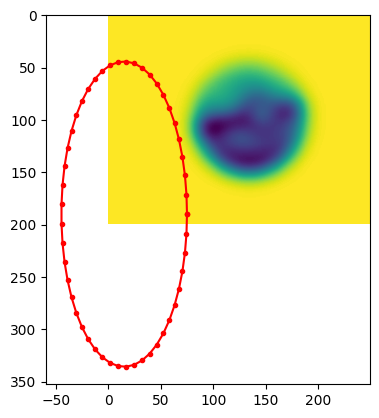

C:\Users\colak\AppData\Local\Temp\ipykernel_5708\2920040386.py:36: RuntimeWarning: invalid value encountered in divide
  E_imag = E_imag/norm(E_imag)


num_updated_points : 20


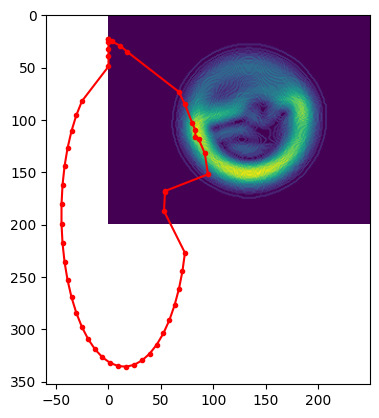

In [12]:
image, contour, kwargs = run_own()

# show initial image & contour
plt.imshow(image)
plt.plot(contour[1, :], contour[0, :], 'r.-')
plt.show()

# run snake
snake(image, contour, **kwargs)

# Examples for keyword arguments orientation

In [14]:
# set keyword arguments pure circles
kwargs = {    
    'neighborhood_size': 14,
    'contour_fraction': 0.1,
    'alpha': 1.,
    'beta': 1.,
    'gamma': 1.,
    'begin_corner_elim': 100,
    'K_threshold': 1
}

# set keyword arguments pure squares
kwargs = {
    'neighborhood_size': 14, 
    'contour_fraction': 0.1,
    'alpha': 1.,
    'beta': 0.,
    'gamma': 1,
    'begin_corner_elim': 1,
    'K_threshold': 0.1
}
